# Прогнозирование температуры звезды

In [1]:
!pip install torch==1.10.0+cpu torchvision==0.11.0+cpu torchaudio==0.10.0 -f https://download.pytorch.org/whl/torch_stable.html --user

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
import numpy as np
import pandas as pd
import random
from math import ceil
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from tqdm import tqdm
import copy

SEED = 42
torch.manual_seed(SEED);

## Загрузка данных

In [3]:
data = pd.read_csv('/datasets/6_class.csv')

In [4]:
display(data.head())
display(data.info())
display(data.describe())

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


None

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,119.50000,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,69.42622,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,0.00000,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,59.75000,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,119.50000,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,179.25000,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,239.00000,40000.000000,849420.000000,1948.500000,20.060000,5.000000


В таблице с данными 240 запсией и 7 столбцов: два с категориальными признаками, три с числовыми, столбец с целевым признаком `Temperature (K)` и номер звезды в списке. Пропусков нет. В значениях числовых признаков есть очень большой разброс. 

## Предобработка и анализ данных

Сначала переименуем все столбцы для удобной работы и удалим индекс звезды:

In [5]:
data = data.rename(columns={'Unnamed: 0':'index',
                            'Temperature (K)':'temperature',
                            'Luminosity(L/Lo)':'luminosity',
                            'Radius(R/Ro)':'radius',
                            'Absolute magnitude(Mv)':'magnitude',
                            'Star type':'type',
                            'Star color':'color'}).drop('index', axis=1)

In [6]:
data['color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

In [7]:
data['color'] = data['color'].str.lower().str.strip()\
                             .replace(regex=r'-', value=' ')
data['color'].value_counts()

red                   112
blue                   56
blue white             41
white                  10
yellow white            8
yellowish               3
yellowish white         3
orange                  2
whitish                 2
pale yellow orange      1
orange red              1
white yellow            1
Name: color, dtype: int64

В столбце с цветом звезды есть неявные дубликаты. После их замены уникальных значений осталось всего 12, большая часть из которых встречается менее 10 раз. Сгруппируем их, оставив значения `blue`, `blue white`, `white`, `yellow` и `red`:

In [8]:
data['color'] = data['color'].replace(['yellow white', 'yellowish', 'yellowish white', 'white yellow',
                        'orange', 'orange red', 'pale yellow orange', 'whitish'],
                      ['white', 'yellow', 'white', 'yellow',
                       'yellow', 'red', 'yellow', 'white'])
data['color'].value_counts()

red           113
blue           56
blue white     41
white          23
yellow          7
Name: color, dtype: int64

Сам цвет звезды нам не так важен, как его расположение на шкале "красный-синий". Расставим цвета по порядку и дадим им числовое обозначение:

In [9]:
data['color'] = data['color'].replace(['red', 'yellow', 'white', 'blue white', 'blue'], [0, 1, 2, 3, 4])

In [10]:
data['type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: type, dtype: int64

Типов звезд 6, в данных равное количество звезд каждого типа. Видимо, выборка была создана так специально.

Далее разберем количественные признаки.

In [11]:
data.describe()

,temperature,luminosity,radius,magnitude,type,color
count,240.000000,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000,1.666667
std,9552.425037,179432.244940,517.155763,10.532512,1.711394,1.708131
min,1939.000000,0.000080,0.008400,-11.920000,0.000000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000,0.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000,1.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000,3.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000,4.000000


В столбце `luminosity` гигантская разница в значениях. В радиусах разница меньше, но она все еще большая. В `magnitude` такого разброса нет.

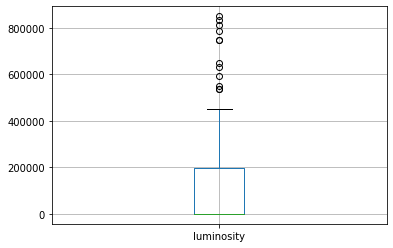

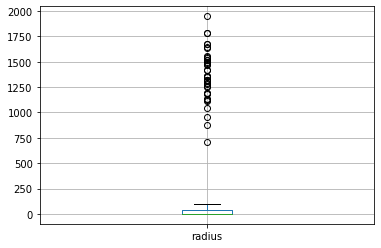

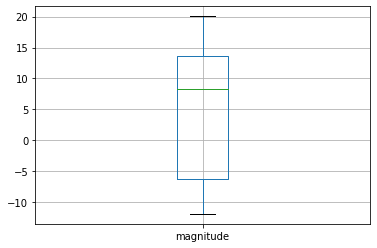

In [12]:
data.boxplot('luminosity'); plt.show();
data.boxplot('radius');     plt.show();
data.boxplot('magnitude');  plt.show();

Большой разброс в светимости и радиусе также виден на графиках. Все выбросы здесь могут и не быть выбросами - звезды бывают разного типа и цвета, все выбивающиеся значения могут принадлежать определенной группе звезд.

Разобьем на группы по типу и цвету звезды остальные признаки.

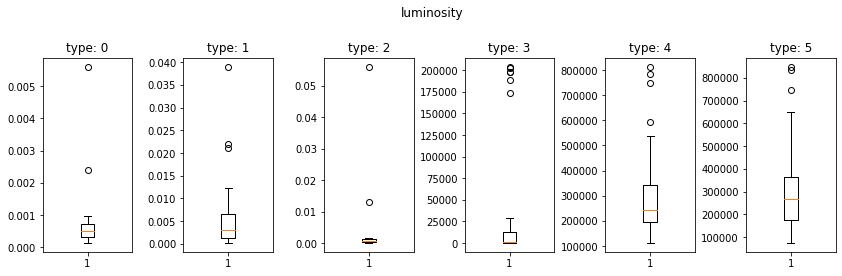

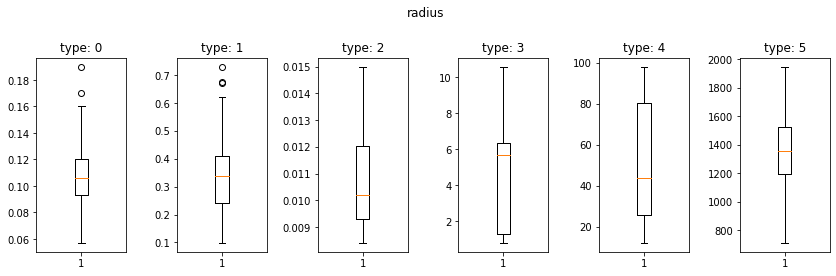

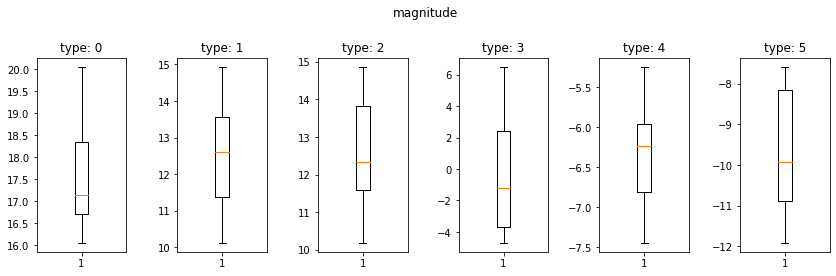

In [13]:
for n in ['luminosity', 'radius', 'magnitude']:
    fig, ax = plt.subplots(1, len(data['type'].unique()), figsize=(12, 4), sharey=False)
    fig.suptitle(str(n))
    fig.tight_layout(pad=2)
    for i in data['type'].sort_values().unique():
        ax[i].boxplot(data[data['type'] == i][n])
        ax[i].set_title('type: ' + str(i))

В `magnitude` нет выбросов ни в одном типе. В `radius` всего несколько в типах 0 и 1. В `luminosity` их уже намного больше, причем они расположены далеко от медианы.

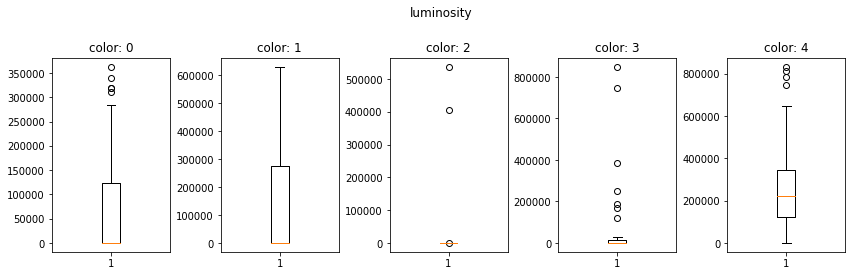

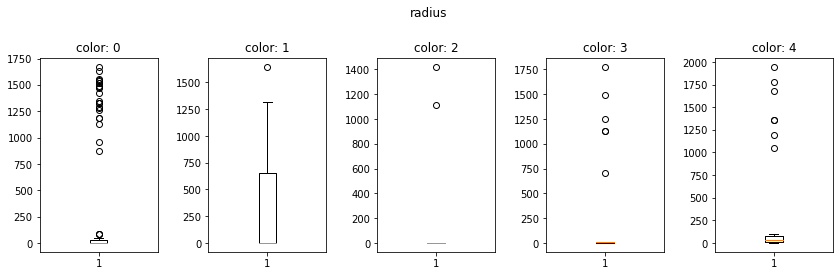

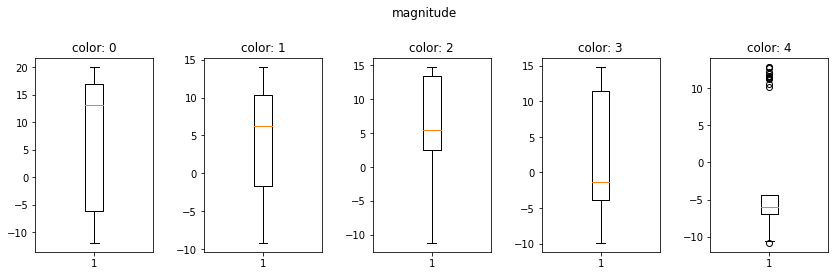

In [14]:
for n in ['luminosity', 'radius', 'magnitude']:
    fig, ax = plt.subplots(1, len(data['color'].unique()), figsize=(12, 4), sharey=False)
    fig.suptitle(str(n))
    fig.tight_layout(pad=2)
    for i in data['color'].sort_values().unique():
        ax[i].boxplot(data[data['color'] == i][n])
        ax[i].set_title('color: ' + str(i))

В группах, разбитых по цвету, выбросов гораздо больше. Медиана светимости и радиуса в 9 из 10 случаев близка к нулю, а значения светимости и радиуса прыгают до 850 тыс. и до 2 тыс.. В `magnitude` также есть кучка выбросов.

Выбивающиеся значения не принадлежат определенной группе звезд, они так же разбросаны по группам. Их придется скорректировать, чтобы улучшить обучаемость модели.     
В данных по 40 звезд каждого типа и разное количество звезд каждого цвета. Странное распределение внутри цветовых групп скорее всего связано с малым количеством записей с определенными цветами. Корректировать значения есть смысл только для типов звезд.

In [15]:
for i in ['luminosity', 'radius', 'magnitude']:
    for n in data['type'].unique():
        t = data[data['type'] == n].copy()
        
        Q1 = t[i].quantile(0.25)
        Q3 = t[i].quantile(0.75)
        IQR = Q3 - Q1
        outliers_low = t.loc[(t[i] <= Q1 - 1.5 * IQR)]
        outliers_high = t.loc[(t[i] >= Q3 + 1.5 * IQR)]
        
        data.loc[outliers_low.index.values, i] = Q1
        data.loc[outliers_high.index.values, i] = Q3       

Заменили выбивающиеся значения на значения первого и третьего квантиля.    
Слишком малыми значениями считаем те, что меньше первого квантиля на 1.5 межквартильных размаха IQR, слишком большими - те, что больше чем третий квантиль на 1.5 IQR.

### Анализ данных 

Посмотрим от каких признаков может зависеть температура звезды.

In [16]:
# функция для отображения графиков
def temp_graphs(data, column, value, desc, figsize, gtype='bar'):
    d = data.pivot_table(index=column, values=[value], aggfunc='median').reset_index()
    if gtype == 'bar':
        ax = plt.subplot()
        d[value].plot(kind='bar', figsize=figsize, alpha=0.8, grid=True)
        ax.set_xticklabels(d[column].sort_values().unique())
        plt.xlabel(desc)
    if gtype == 'hist':
        d.plot(kind='scatter', x=value, y=column, figsize=figsize, alpha=0.6, grid=True)
        plt.ylabel(column)
        plt.xlabel(desc)
    plt.show();

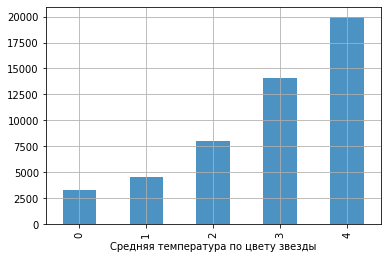

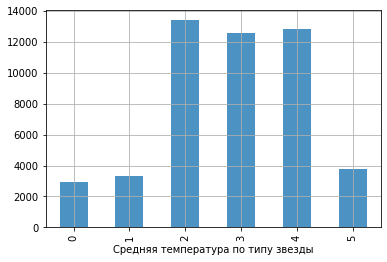

In [17]:
temp_graphs(data, 'color', 'temperature', 'Средняя температура по цвету звезды', (6, 4))
temp_graphs(data, 'type', 'temperature', 'Средняя температура по типу звезды', (6, 4))

У температуры и цвета явно видна зависимость - чем синее, тем обычно горячее звезда. В типах такого не видно, ведь тип это не одна шкала: в него входит и размер, и цвет звезды, и наверное что-нибудь еще. Самые холодные звезды 0, 1 и 5 типов, самые горячие - 2, 3 и 4.

Что может влиять на цвет и тип?

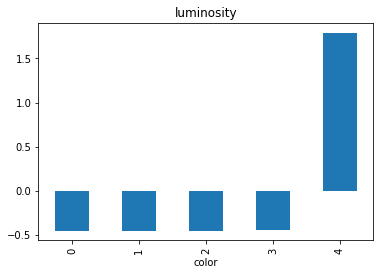

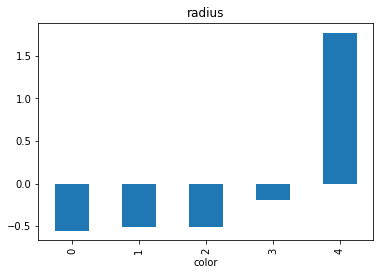

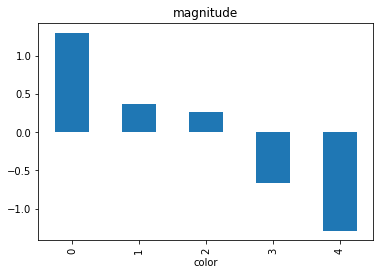

In [18]:
color = pd.pivot_table(data, columns='color', values=data.drop('color', axis=1).columns, aggfunc='median').T
for n in ['luminosity', 'radius', 'magnitude']:
    # нормализуем значения из-за гигантской разницы в них
    color.iloc[:,:].apply(lambda x: (x - x.mean())/ x.std(), axis=0)[n].plot(kind='bar');
    plt.title(n); plt.show();

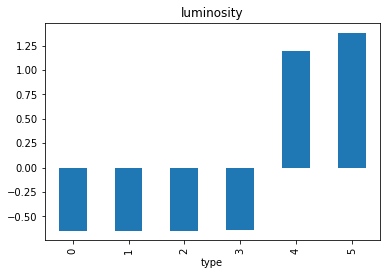

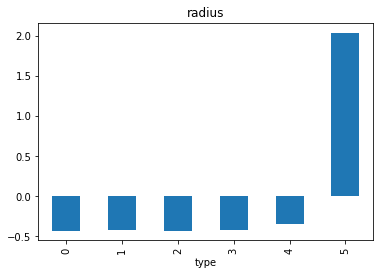

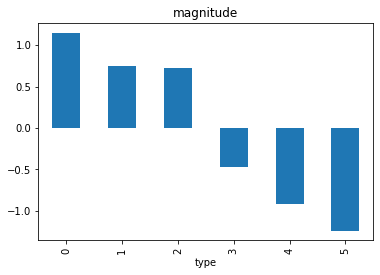

In [19]:
stype = pd.pivot_table(data, columns='type', values=data.drop('type', axis=1).columns, aggfunc='median').T
for n in ['luminosity', 'radius', 'magnitude']:
    stype.iloc[:,:].apply(lambda x: (x - x.mean())/ x.std(), axis=0)[n].plot(kind='bar');
    plt.title(n); plt.show();

Ни с цветом, ни с типом у светимости и радиуса нет зависимости - только последние группы цвета и типа имеют большие значения этих признаков. Блеск для цвета и типа тоже похож - чем меньше блеск, тем больше номер группы.

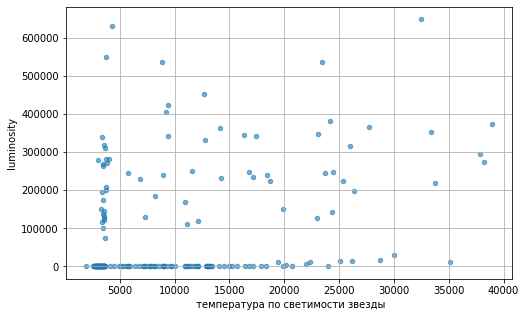

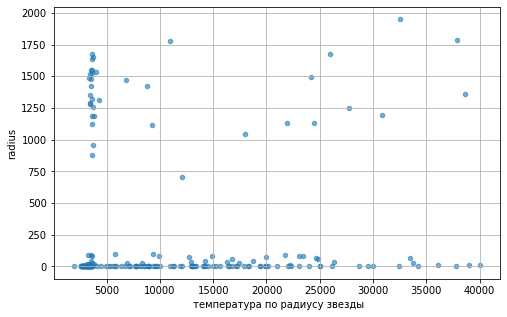

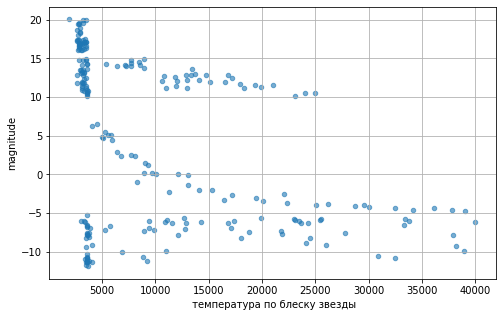

In [20]:
temp_graphs(data, 'luminosity', 'temperature', ' температура по светимости звезды', (8, 5), gtype='hist')
temp_graphs(data, 'radius', 'temperature', ' температура по радиусу звезды', (8, 5), gtype='hist')
temp_graphs(data, 'magnitude', 'temperature', ' температура по блеску звезды', (8, 5), gtype='hist')

Кажется, будто ни от чего остального температура не зависит: много значений сконцентрированы около осей графика, оставшиеся хаотично разбросаны. Блеск звезды еще как-то связан с температурой - большинство звезд менее 5000К имеют блеск от 10 до 20 Mv, звезды от 25000 до 40000 К имеют только отрицательный блеск, но звезды других температур могут иметь практически любое значение блеска.

Последнее, что осталось узнать - влияют ли параметры друг на друга?

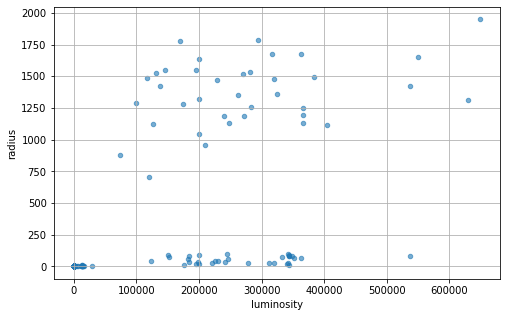

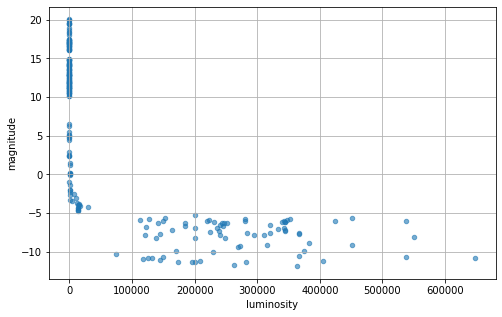

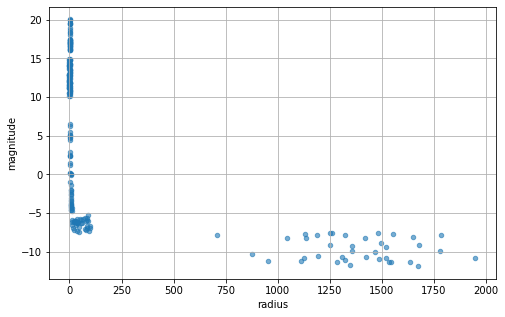

In [21]:
temp_graphs(data, 'radius', 'luminosity', 'luminosity', (8, 5), gtype='hist')
temp_graphs(data, 'magnitude', 'luminosity', 'luminosity', (8, 5), gtype='hist')
temp_graphs(data, 'magnitude', 'radius', 'radius', (8, 5), gtype='hist')

Радиус и светимость, похоже, никак не связаны - у звезды с радиусом около нуля может быть любая светимость, так же как и у звезд с другими радиусами. У блеска графики похожи - у звезд с радиусом и светимостью около нуля блеск может быть от -6 до 20 Mv. Блеск ниже -6 может быть у любых звезд.

В итоге стало ясно, что у температуры есть четкая зависимость только с цветом звезды, цвет и тип связаны с блеском, а радиус и светимость могут быть любые у любых звезд.

### Тестовая выборка

Теперь поделим данные на обучающую, валидационную и тестовую выборки. Проведем ОНЕ кодирование категориальных признаков и MinMax масштабирование числовых:

In [22]:
X_train_, X_, y_train, y_ = train_test_split(data.drop('temperature', axis=1), data['temperature'], test_size=0.4,
                                                      shuffle=True, stratify=data['color'], random_state=SEED)
X_val_, X_test_, y_val, y_test = train_test_split(X_, y_, test_size=0.5,
                                                      shuffle=True, stratify=X_['color'], random_state=SEED)

In [23]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
scaler = MinMaxScaler(feature_range=(-1, 1))

scaler.fit(X_train_[X_train_.columns[:-2]])
encoder.fit(X_train_[['color', 'type']])

X_train = pd.concat([pd.DataFrame(scaler.transform(X_train_.drop(['color', 'type'], axis=1))),
           pd.DataFrame(encoder.transform(X_train_[['color', 'type']]))], axis=1)
X_val = pd.concat([pd.DataFrame(scaler.transform(X_val_.drop(['color', 'type'], axis=1))),
           pd.DataFrame(encoder.transform(X_val_[['color', 'type']]))], axis=1)
X_test = pd.concat([pd.DataFrame(scaler.transform(X_test_.drop(['color', 'type'], axis=1))),
           pd.DataFrame(encoder.transform(X_test_[['color', 'type']]))], axis=1)

X_train = torch.FloatTensor(X_train.values)
X_val = torch.FloatTensor(X_val.values)
X_test = torch.FloatTensor(X_test.values)
y_train = torch.FloatTensor(y_train.values)
y_val = torch.FloatTensor(y_val.values)
y_test = torch.FloatTensor(y_test.values)

In [24]:
X_test.shape

torch.Size([48, 14])

## Построение базовой нейронной сети

Прежде чем строить саму модель, можно сделать функцию для ее обучения. Обычный цикл обучения нейронной сети: оптимизатор обнуляет градиенты, сеть обсчитывает тренировочные данные, вычисляется значение функции потерь и ее градиент, оптимизатор обновляет веса, и наконец считается метрика качества. Такой цикл - одна эпоха обучения.

В функции `net_train` 1000 эпох, каждую сотую эпоху будет проверяться качество модели. Метрика качества - RMSE.      
Функция принимает на вход модель, скорость обучения, количество эпох и тренировочную и тестовую выборки. Возвращает предсказания на тестовой выборке и промежуточные результаты обучения.

In [25]:
def net_train(model, learn_rate, X_train, y_train, X_test, y_test, num_epochs=1000, info=False):
    torch.manual_seed(SEED) # выставляем seed в начале обучения для воспроизводимости результатов
    train_stat = []; test_stat = []
    
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)  
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        
        preds = model.forward(X_train).flatten()
        train_loss = loss(preds, y_train)
        train_loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0 or epoch == num_epochs - 1:
            with torch.no_grad():
                model.eval()
                test_preds = model.forward(X_test).flatten()
                test_loss = loss(test_preds, y_test)
                if info:
                    print(f'Эпоха [{epoch+1}/{num_epochs}],   RMSE train: {train_loss**0.5},   RMSE test: {test_loss**0.5}')
                train_stat.append(train_loss**0.5)
                test_stat.append(test_loss**0.5)
    
    return test_preds, train_stat, test_stat

Для того, чтобы увеличить точность модели, придется перебрать несколько параметров, например, количество слоев и скорость обучения, и выбрать лучшую модель. Слои, если немного, можно перебрать и вручную, а перебор гиперпараметров лучше сделать функцией:

In [26]:
def net_tune(model, param):
    scores = []
    for n in tqdm(param):
        val_preds, train_stat, val_stat = net_train(copy.deepcopy(model), n, X_train, y_train, X_val, y_val)
        scores.append((val_stat[-1], n, val_preds, train_stat, val_stat))
    return sorted(scores)[0] 

Также полезной будет функция для отображения результатов обучения:

In [27]:
def trainstat_graph(train_stat, test_stat):
    plt.figure(figsize=(10, 6))
    plt.plot(train_stat, marker='o', color = '#ade2f6', label='train')
    plt.plot(test_stat, marker='o',  color = '#fec000', label='test')
    plt.xlabel("epoch"); plt.ylabel("rmse"); plt.title("Динамика обучения")
    plt.grid(alpha=0.4)
    plt.legend()
    plt.show();

Пример работы:

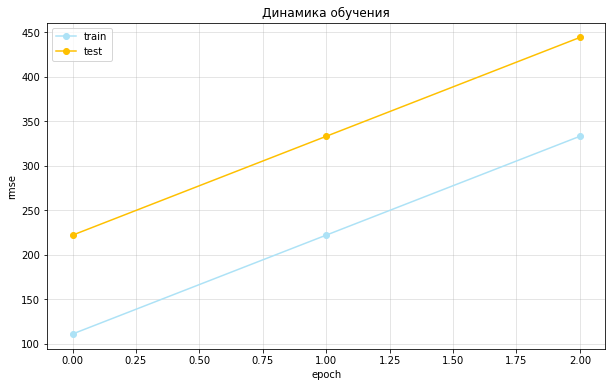

In [28]:
trainstat_graph([111, 222, 333], [222, 333, 444])

И функция для сравнения фактических значений и спрогнозированных:

In [29]:
def predict_graph(y_test, test_preds):
    grouplen = len(y_test)//2

    groups1 = np.arange(len(test_preds))[:grouplen]
    plt.figure(figsize=(12, 5))
    plt.bar(groups1, y_test[:grouplen], color = '#ade2f6', width = 0.6, label='Факт')
    plt.bar(groups1, test_preds.detach().numpy()[:grouplen], color = '#fec000', width = 0.25, label='Прогноз')
    plt.xticks(groups1)
    plt.xlabel("Номер звезды"); plt.ylabel("Температура, К"); plt.title("Сравнение факта и прогноза")
    plt.grid(alpha=0.4)
    plt.legend()

    groups2 = np.arange(len(test_preds))[grouplen:]
    plt.figure(figsize=(12, 5))
    plt.bar(groups2, y_test[grouplen:], color = '#ade2f6', width = 0.6, label='Факт')
    plt.bar(groups2, test_preds.detach().numpy()[grouplen:], color = '#fec000', width = 0.25, label='Прогноз')
    plt.xticks(groups2)
    plt.xlabel("Номер звезды в таблице "); plt.ylabel("Температура, К"); plt.title("Сравнение факта и прогноза")
    plt.grid(alpha=0.4)
    plt.legend()

    plt.show();

Пример работы:

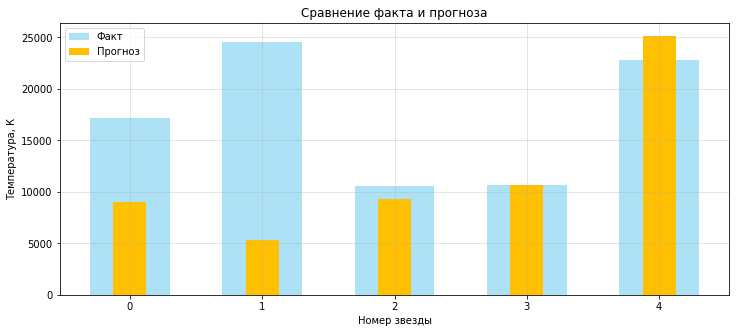

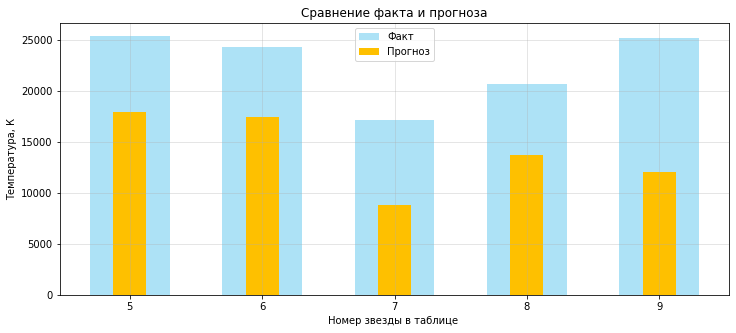

In [30]:
predict_graph(torch.Tensor(np.random.randint(low=5000, high=30000, size = 10)),
              torch.Tensor(np.random.randint(low=5000, high=30000, size = 10)))

В тестовой выборке 48 значений. Если вывести их в одну строку, на такой график будет сложно смотреть. Функция поделит график на две части.

Теперь к созданию самой модели.            
Сначала нужно найти хорошую базовую структуру нейронной сети.

### 1 слой

Первой сделаем модель с одним скрытым слоем:

In [31]:
class BaseNet1(nn.Module):
    def __init__(self, input_size, hidden_size1, n_out_neurons):
        super(BaseNet1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, n_out_neurons)
        
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        
        out = self.fc2(out)
        return out

Количество нейронов на скрытом слое - 4. Это близко к рекомендуемому значению, равному $ \sqrt{input\ size*output\ size} $.    
Изменять нейроны не будем. Лучше переберем значения для скорости обучения:

In [32]:
input_size = 14
hidden_size1 = 4
n_out_neurons = 1

learn_param = [0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1]

model = BaseNet1(input_size, hidden_size1, n_out_neurons)

scores = net_tune(model, learn_param)
scores[:2]

100%|██████████| 7/7 [00:18<00:00,  2.68s/it]


(tensor(5638.2295), 0.1)

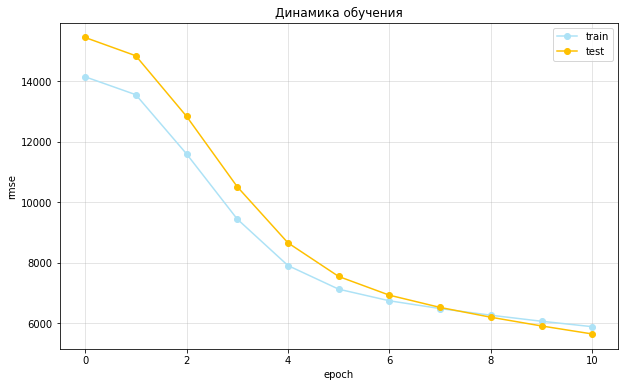

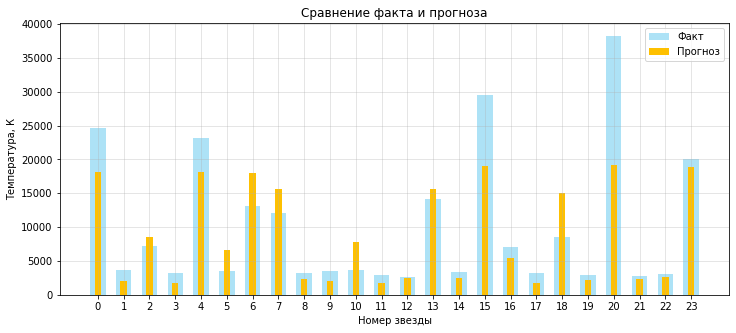

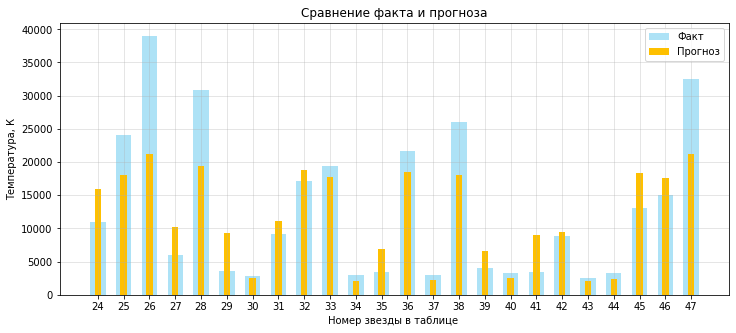

In [33]:
trainstat_graph(scores[3], scores[4])
predict_graph(y_val, scores[2])

Лучшая RMSE - 5638, что для начала не плохо. График обучения плавный, метрика улучшается на всем протяжении. С 800 эпохи ошибка на валидационной выборке становится меньше, чем на обучающей. Из графиков с фактом и прогнозом видно, что модель плохо определяет значения больше 20000 тысяч.

### 2 слоя

Попробуем добавить слой:

In [34]:
class BaseNet2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, n_out_neurons):
        super(BaseNet2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, n_out_neurons)
        
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        return out

In [35]:
input_size = 14
hidden_size1 = 7
hidden_size2 = 4
n_out_neurons = 1

model = BaseNet2(input_size, hidden_size1, hidden_size2, n_out_neurons)

scores = net_tune(model, learn_param)
scores[:2]

100%|██████████| 7/7 [00:26<00:00,  3.72s/it]


(tensor(3126.0593), 0.06)

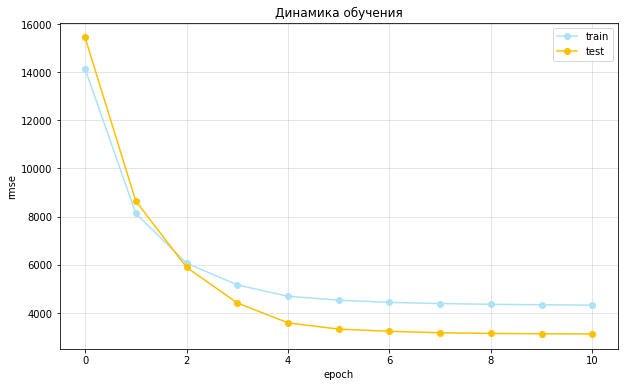

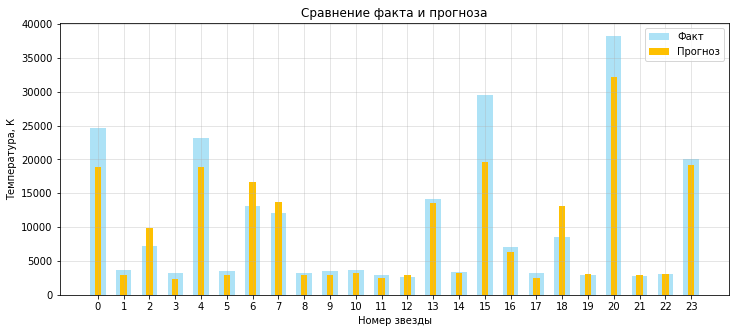

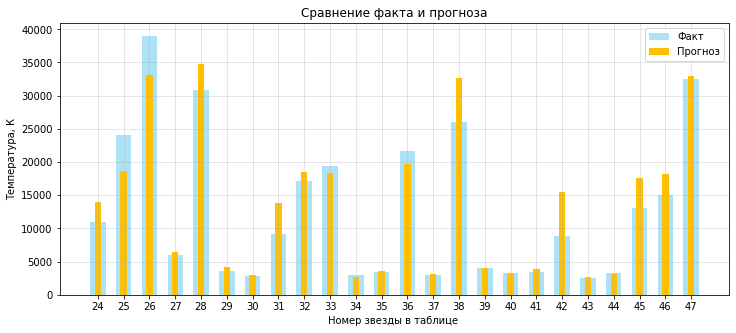

In [36]:
trainstat_graph(scores[3], scores[4])
predict_graph(y_val, scores[2])

После добавления второго слоя ошибка уменьшилась почти на 2500 единиц! Факт и прогноз отличаются меньше, модель начала предсказывать значения до 35000. График обучения более крутой, после 600 эпохи улучшения метрики нет.

Валидационная ошибка стала меньше тренировочной уже на 200 эпохе - это может говорить либо об ошибке в коде, либо о неравном распределении в данных. Второе более вероятно: данных для обучения было довольно мало и, не смотря на перемешивание и стратификацию, в тренировочную выборку попали более сложные данные для обобщения, а в валидационную более легкие для предсказания.

### 3 слоя

Добавим еще один слой.

In [37]:
class BaseNet3(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, n_out_neurons):
        super(BaseNet3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, n_out_neurons)
        
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        out = self.relu(out)
        
        out = self.fc4(out)
        return out

In [38]:
input_size = 14
hidden_size1 = 10
hidden_size2 = 7
hidden_size3 = 4
n_out_neurons = 1 

model = BaseNet3(input_size, hidden_size1, hidden_size2, hidden_size3, n_out_neurons)

scores = net_tune(model, learn_param)
scores[:2]

100%|██████████| 7/7 [00:32<00:00,  4.67s/it]


(tensor(3129.7925), 0.01)

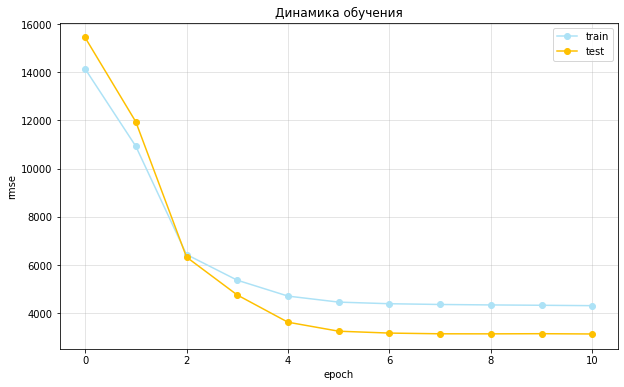

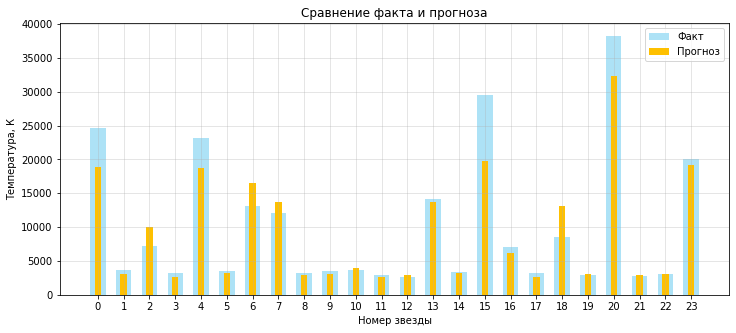

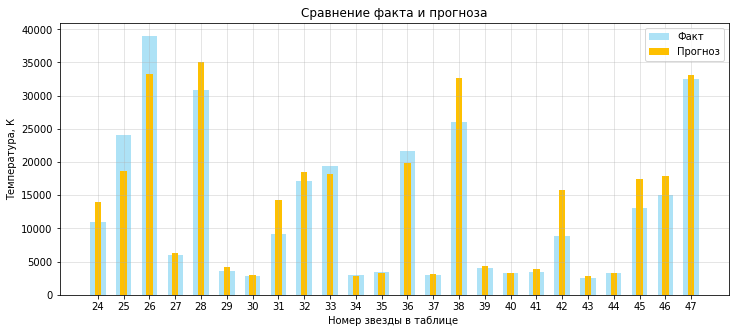

In [39]:
trainstat_graph(scores[3], scores[4])
predict_graph(y_val, scores[2])

Добавление еще одного слоя немного увеличило ошибку. График обучения такой же, как у предыдущей модели, факт-прогноз тоже почти не отличается.

### 4 слоя

Попробуем последний слой.

In [40]:
class BaseNet4(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, n_out_neurons):
        super(BaseNet4, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, n_out_neurons)
        
        nn.init.kaiming_uniform_(self.fc1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc3.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc4.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc5.weight, mode='fan_in', nonlinearity='relu')
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        out = self.relu(out)
        
        out = self.fc4(out)
        out = self.relu(out)
        
        out = self.fc5(out)
        return out

In [41]:
input_size = 14
hidden_size1 = 12
hidden_size2 = 10
hidden_size3 = 7
hidden_size4 = 4
n_out_neurons = 1

model = BaseNet4(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, n_out_neurons)

scores = net_tune(model, learn_param)
scores[:2]

100%|██████████| 7/7 [00:42<00:00,  6.05s/it]


(tensor(3114.7537), 0.003)

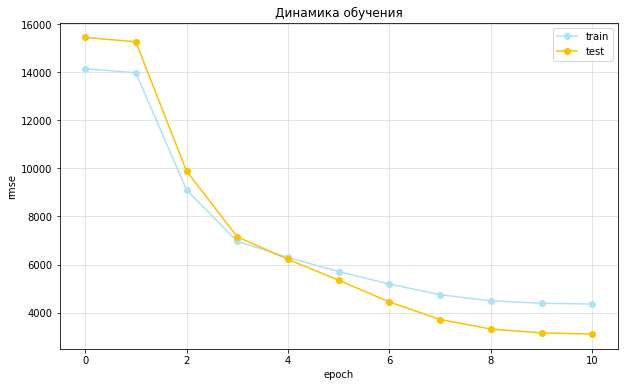

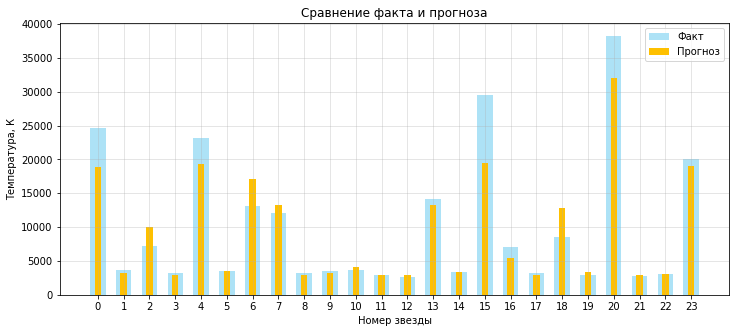

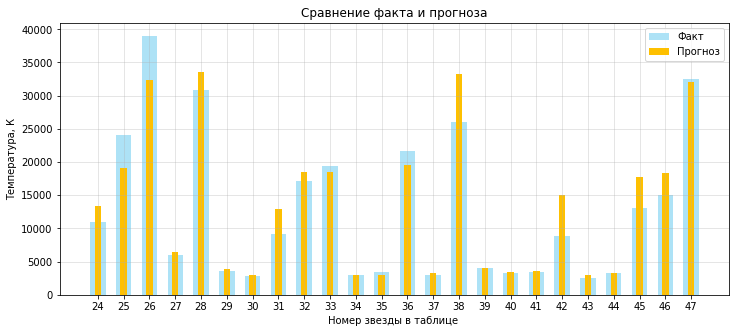

In [42]:
trainstat_graph(scores[3], scores[4])
predict_graph(y_val, scores[2])

Метрика немного улучшилась - 3114. График обучения стал более плавным, нет гигантских скачков в результатах. Теперь улучшение на валидации можно увидеть до 900 эпохи. Ошибка на валидации все так же становится меньше тестовой, но теперь только после 400 эпохи.

По сравнению с 3- и 2-слойными моделями модель с 4 слоями выглядит более стабильной. У них близкие метрики, но при этом у первых двух обучение заканчивается уже на 400-500 эпохе, а у последней продолжается да 900. Также у них разные скорости обучения: у 2-слойной 0.06, у 3-слойной 0.03, а у 4-слойной 0.003. Маленькая скорость позволит модели переобучиться не так быстро.

Возьмем сеть с 4 скрытыми слоями за базовую.

## Улучшение нейронной сети

Улучшить нейронную сеть можно, применив регуляризацию - так у нее будет меньше шансов переобучиться. Сейчас не похоже, что базовая сеть переобучена, но попробовать и сравнить результат можно.

### Batch-norm

Один из распространенных видов регуляризации в нейронных сетях - батч-норм. Он нормализует значения в батчах, полученных из тренировочной выборки, чтобы сеть могла спокойно обучаться, а не отвлекаться на огромную разницу в значениях. Этот способ может помочь со странной разницей в ошибках у базовой модели.

In [43]:
class BatchNet(BaseNet4):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, n_out_neurons, momentum=0.1):
        super().__init__(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, n_out_neurons)
        
        self.bn1 = nn.BatchNorm1d(hidden_size1, momentum=momentum)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        out = self.relu(out)
        
        out = self.fc4(out)
        out = self.relu(out)
        
        out = self.fc5(out)
        return out

У батч-норм есть гиперпараметр `momentum` - он отвечает за влияние среднего значения одного батча на следующий, лежит в пределах от 0 до 1.

In [44]:
input_size = 14
hidden_size1 = 12
hidden_size2 = 10
hidden_size3 = 7
hidden_size4 = 4
n_out_neurons = 1

learn_rate = 0.003

momentum_param = [0, 0.03, 0.06, 0.1, 0.3, 0.6, 1]

scores = []
for n in tqdm(momentum_param):
    model = BatchNet(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, n_out_neurons, momentum=n)
    val_preds, train_stat, val_stat = net_train(model, learn_rate, X_train, y_train, X_val, y_val)
    scores.append((val_stat[-1], n, val_preds, train_stat, val_stat))
scores = sorted(scores)[0]

scores[:2]

100%|██████████| 7/7 [00:50<00:00,  7.21s/it]


(tensor(3168.8503), 0.03)

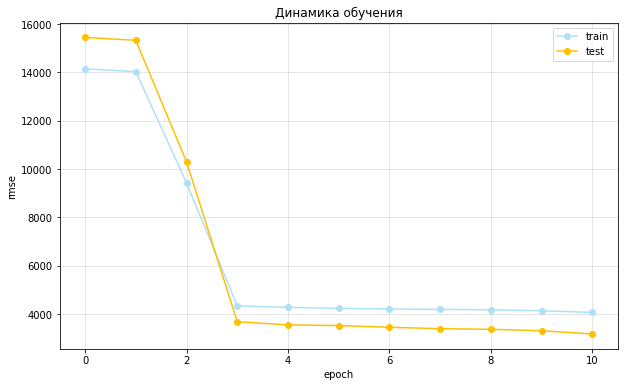

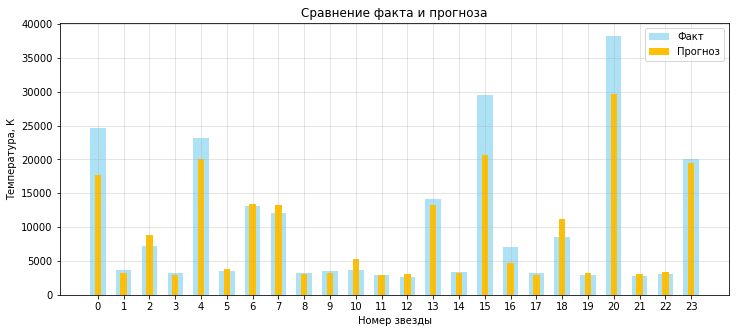

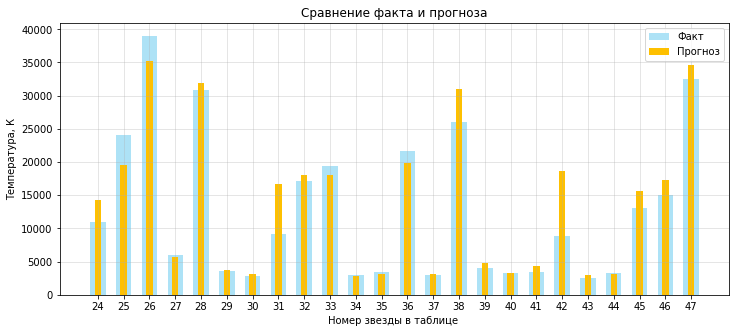

In [45]:
trainstat_graph(scores[3], scores[4])
predict_graph(y_val, scores[2])

Батч-норм не помог улучшить метрику или избавиться от большой тренировочной ошибки. Оптимальное значение `momentum` 0.03 дает минимальную нормализацию батчей. Всего за 200 эпох ошибка снизилась с 15800 до 3900 и после почти не снижалась.

### Dropout

Попробуем еще один вид регуляризации - дропаут. Его используют, чтобы усложнить работу сети и этим уменьшить переобучение. Этот метод выключает часть нейронов из работы сети, не давая им влиять на следующие нейроны. Выключаются случайные нейроны на слое, и каждый раз получается новое строение сети.

In [46]:
class DropNet(BaseNet4):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, n_out_neurons, p=0.2):
        super().__init__(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, n_out_neurons)
                
        self.dp1 = nn.Dropout(p=p)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.dp1(out)
        out = self.relu(out)
        
        out = self.fc2(out)
        out = self.dp1(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        out = self.dp1(out)
        out = self.relu(out)
        
        out = self.fc4(out)
        out = self.relu(out)
        
        out = self.fc5(out)
        return out


Из гиперпараметров у этого метода есть `p` - количество выключаемых нейронов. Оно может быть равным числу от 0 до 1.

In [47]:
input_size = 14
hidden_size1 = 12
hidden_size2 = 10
hidden_size3 = 7
hidden_size4 = 4
n_out_neurons = 1

learn_rate = 0.003

p_param = [0.1, 0.2, 0.4, 0.6, 0.8]

scores = []
for n in tqdm(p_param):
    model = DropNet(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, n_out_neurons, p=n)
    val_preds, train_stat, val_stat = net_train(model, learn_rate, X_train, y_train, X_val, y_val)
    scores.append((val_stat[-1], n, val_preds, train_stat, val_stat))
scores = sorted(scores)[0]

scores[:2]

100%|██████████| 5/5 [00:31<00:00,  6.23s/it]


(tensor(3460.2717), 0.1)

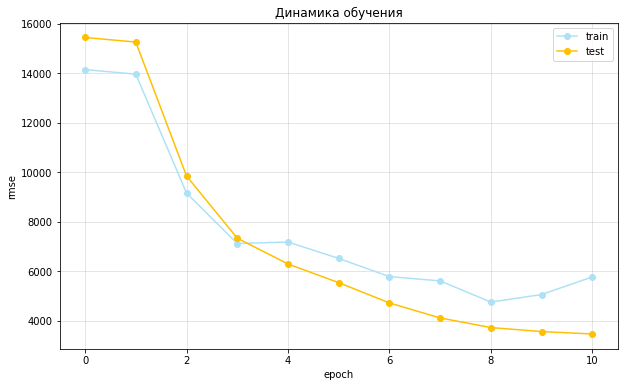

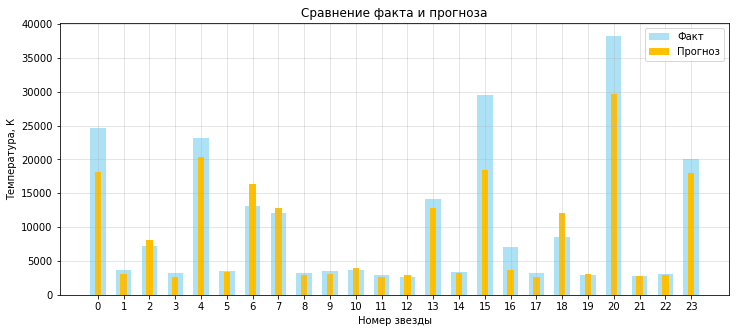

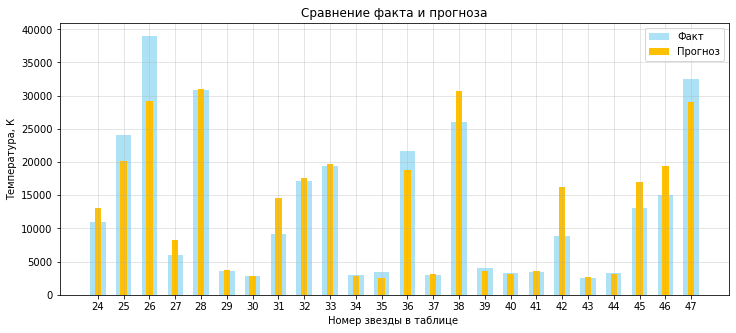

In [48]:
trainstat_graph(scores[3], scores[4])
predict_graph(y_val, scores[2])

Лучшее подобранное `p` равно 0.1, что значит выключено всего 10% нейронов, а это один нейрон на 1, 2 и 3 слоях. Результат хуже базовой модели на 240К. После 300 эпохи `train` снова больше чем `test`, а начиная с 800 вообще растет. Модель, как обычно, хорошо предсказывает температуры до 5000К.

## Тест моделей

Теперь пора сравнить, как себя ведут модели на тестовых данных.

Для сравнения возьмем 3 модели: базовую, с батч-норм и с дропаут.

Эпоха [1/1000],   RMSE train: 14141.5859375,   RMSE test: 12920.818359375
Эпоха [101/1000],   RMSE train: 14064.966796875,   RMSE test: 12834.2880859375
Эпоха [201/1000],   RMSE train: 11124.484375,   RMSE test: 9567.4404296875
Эпоха [301/1000],   RMSE train: 7465.6923828125,   RMSE test: 6141.431640625
Эпоха [401/1000],   RMSE train: 6740.64453125,   RMSE test: 5650.15478515625
Эпоха [501/1000],   RMSE train: 6247.8779296875,   RMSE test: 5290.681640625
Эпоха [601/1000],   RMSE train: 5767.15673828125,   RMSE test: 4995.73486328125
Эпоха [701/1000],   RMSE train: 5365.18408203125,   RMSE test: 4834.00537109375
Эпоха [801/1000],   RMSE train: 5019.08056640625,   RMSE test: 4773.46826171875
Эпоха [901/1000],   RMSE train: 4762.1123046875,   RMSE test: 4794.83154296875
Эпоха [1000/1000],   RMSE train: 4594.8115234375,   RMSE test: 4820.55908203125


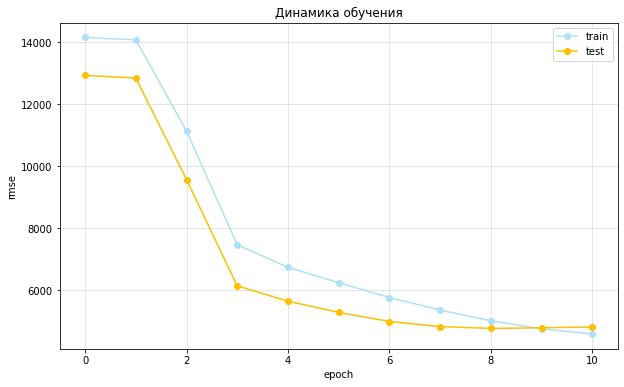

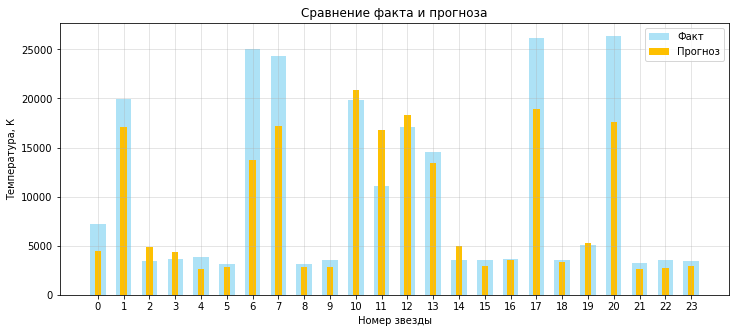

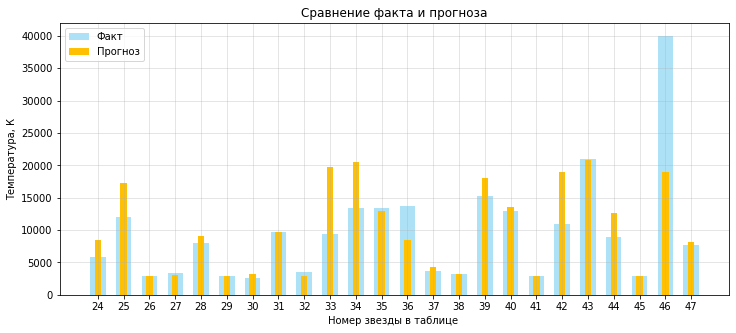

In [49]:
input_size = 14
hidden_size1 = 12
hidden_size2 = 10
hidden_size3 = 7
hidden_size4 = 4
n_out_neurons = 1

learn_rate = 0.003

model = BaseNet4(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, n_out_neurons)
base_preds, base_train, base_test = net_train(model, learn_rate, X_train, y_train, X_test, y_test, info=True)

trainstat_graph(base_train, base_test)
predict_graph(y_test, base_preds)

Эпоха [1/1000],   RMSE train: 14141.2109375,   RMSE test: 12920.412109375
Эпоха [101/1000],   RMSE train: 14024.767578125,   RMSE test: 12825.806640625
Эпоха [201/1000],   RMSE train: 9423.453125,   RMSE test: 9090.6904296875
Эпоха [301/1000],   RMSE train: 4333.07763671875,   RMSE test: 4906.35400390625
Эпоха [401/1000],   RMSE train: 4270.513671875,   RMSE test: 4743.8037109375
Эпоха [501/1000],   RMSE train: 4226.73095703125,   RMSE test: 4653.6259765625
Эпоха [601/1000],   RMSE train: 4201.80419921875,   RMSE test: 4679.73193359375
Эпоха [701/1000],   RMSE train: 4185.82666015625,   RMSE test: 4653.19677734375
Эпоха [801/1000],   RMSE train: 4168.61181640625,   RMSE test: 4680.55419921875
Эпоха [901/1000],   RMSE train: 4127.69677734375,   RMSE test: 4637.81298828125
Эпоха [1000/1000],   RMSE train: 4059.58544921875,   RMSE test: 4650.29052734375


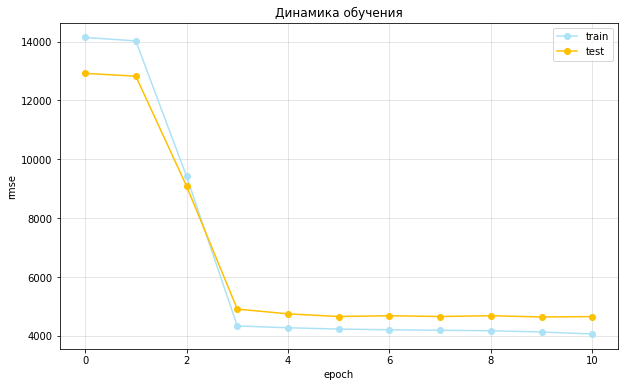

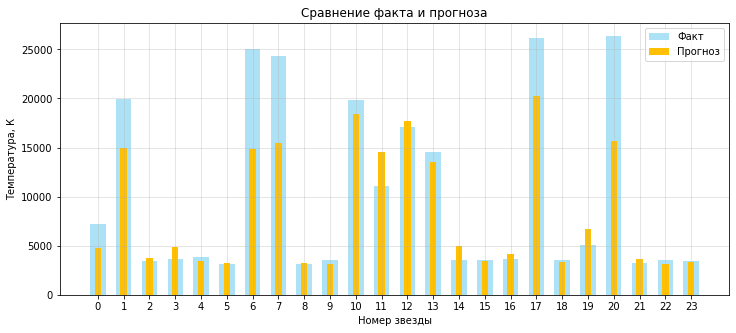

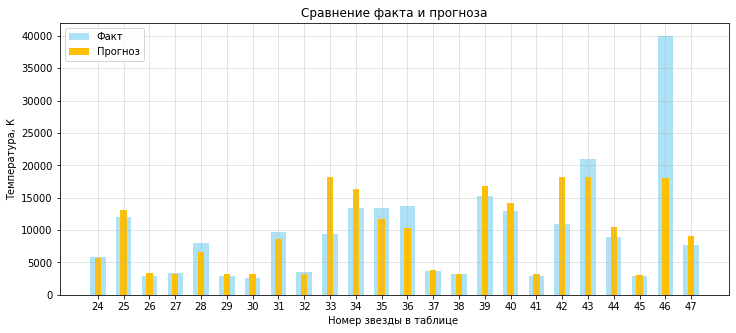

In [50]:
momentum = 0.03

model = BatchNet(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, n_out_neurons, momentum)
batch_preds, batch_train, batch_test = net_train(model, learn_rate, X_train, y_train, X_test, y_test, info=True)

trainstat_graph(batch_train, batch_test)
predict_graph(y_test, batch_preds)

Эпоха [1/1000],   RMSE train: 14141.158203125,   RMSE test: 12920.408203125
Эпоха [101/1000],   RMSE train: 13959.279296875,   RMSE test: 12717.6259765625
Эпоха [201/1000],   RMSE train: 9152.5712890625,   RMSE test: 7358.28369140625
Эпоха [301/1000],   RMSE train: 7115.6552734375,   RMSE test: 5792.0302734375
Эпоха [401/1000],   RMSE train: 7175.29150390625,   RMSE test: 5352.79296875
Эпоха [501/1000],   RMSE train: 6513.56591796875,   RMSE test: 5012.57373046875
Эпоха [601/1000],   RMSE train: 5778.45361328125,   RMSE test: 4854.75146484375
Эпоха [701/1000],   RMSE train: 5604.88818359375,   RMSE test: 4848.9365234375
Эпоха [801/1000],   RMSE train: 4748.8125,   RMSE test: 4873.83203125
Эпоха [901/1000],   RMSE train: 5054.560546875,   RMSE test: 4876.30859375
Эпоха [1000/1000],   RMSE train: 5765.8798828125,   RMSE test: 4887.931640625


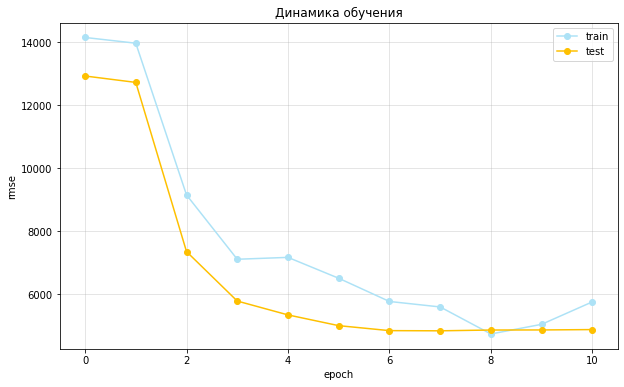

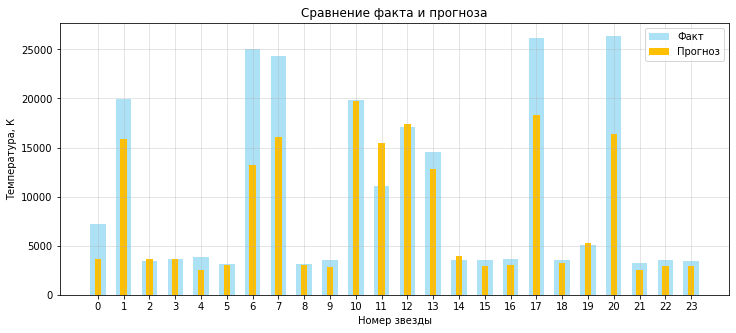

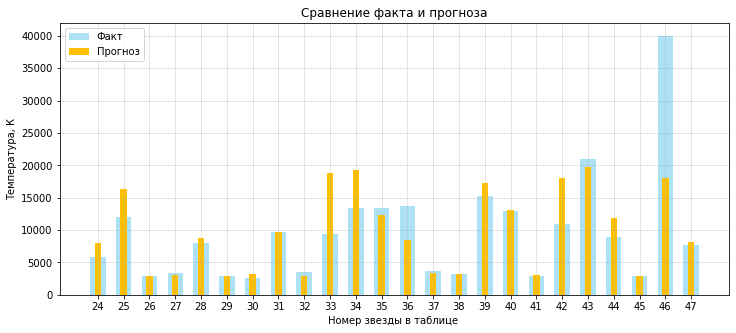

In [51]:
p = 0.1

model = DropNet(input_size, hidden_size1, hidden_size2, hidden_size3, hidden_size4, n_out_neurons, p)
drop_preds, drop_train, drop_test = net_train(model, learn_rate, X_train, y_train, X_test, y_test, info=True)

trainstat_graph(drop_train, drop_test)
predict_graph(y_test, drop_preds)

## Выводы

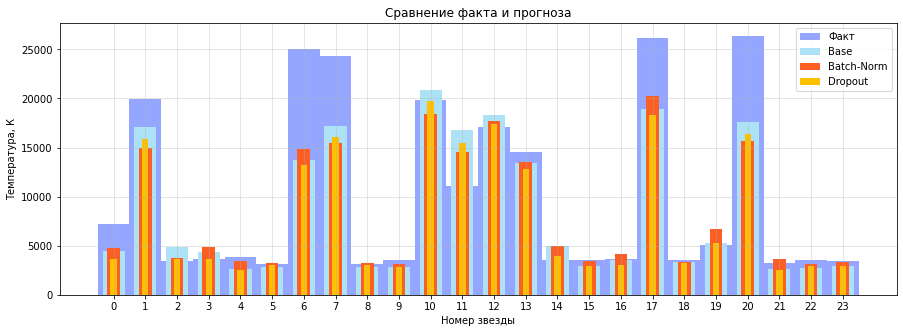

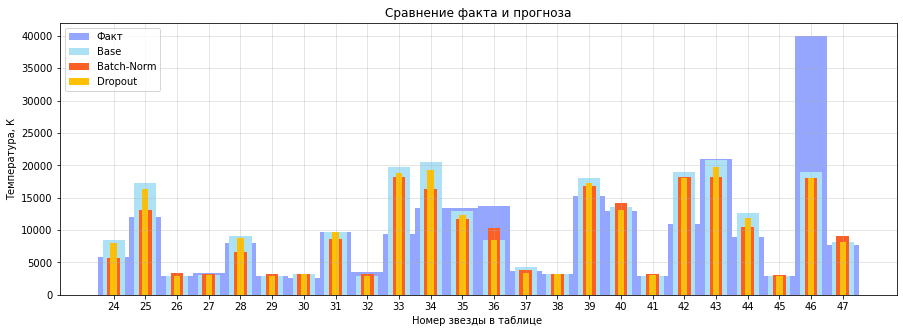

In [52]:
grouplen = len(y_test)//2

groups1 = np.arange(len(y_test))[:grouplen]
plt.figure(figsize=(15, 5))
plt.bar(groups1, y_test[:grouplen], color = '#94a6ff', width = 1, label='Факт')
plt.bar(groups1, base_preds.detach().numpy()[:grouplen], color = '#ade2f6', width = 0.7, label='Base')
plt.bar(groups1, batch_preds.detach().numpy()[:grouplen], color = '#fc5f24', width = 0.4, label='Batch-Norm')
plt.bar(groups1, drop_preds.detach().numpy()[:grouplen], color = '#fec000', width = 0.2, label='Dropout')
plt.xticks(groups1)
plt.xlabel("Номер звезды"); plt.ylabel("Температура, К"); plt.title("Сравнение факта и прогноза")
plt.grid(alpha=0.4)
plt.legend()

groups2 = np.arange(len(y_test))[grouplen:]
plt.figure(figsize=(15, 5))
plt.bar(groups2, y_test[grouplen:], color = '#94a6ff', width = 1, label='Факт')
plt.bar(groups2, base_preds.detach().numpy()[grouplen:], color = '#ade2f6', width = 0.7, label='Base')
plt.bar(groups2, batch_preds.detach().numpy()[grouplen:], color = '#fc5f24', width = 0.4, label='Batch-Norm')
plt.bar(groups2, drop_preds.detach().numpy()[grouplen:], color = '#fec000', width = 0.2, label='Dropout')
plt.xticks(groups2)
plt.xlabel("Номер звезды в таблице "); plt.ylabel("Температура, К"); plt.title("Сравнение факта и прогноза")
plt.grid(alpha=0.4)
plt.legend()

plt.show();

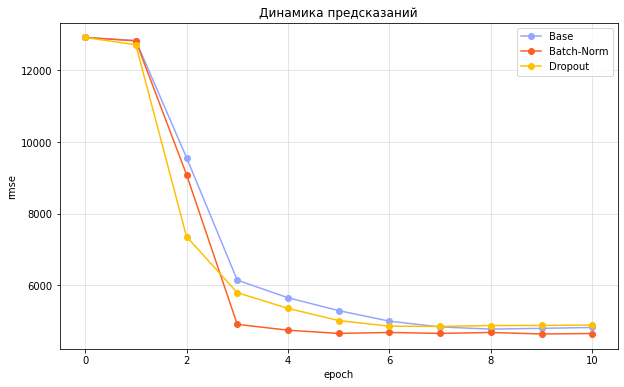

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(base_test, marker='o', color = '#94a6ff', label='Base')
plt.plot(batch_test, marker='o', color = '#fc5f24', label='Batch-Norm')
plt.plot(drop_test, marker='o', color = '#fec000', label='Dropout')
plt.xlabel("epoch"); plt.ylabel("rmse"); plt.title("Динамика предсказаний")
plt.grid(alpha=0.4)
plt.legend()
plt.show();

На графике с фактом и прогнозом видно, что:
- все три модели одинаково хорошо определяют температуру ниже 5000К;
- все три плохо справляются с температурами 20000К и выше;
- со средними температурами справляются средне;
- базовая модель часто предсказывает температуру больше, чем остальные.

График с динамикой предсказания показывает, что:
- у базовой модели худшие предсказания с 100 по 600 эпоху;
- у дропаут самый плавный график и наименьшая ошибка на 200 эпохе;
- батч-норм выделяется резким уменьшением ошибки до 300 эпохи, но после этого улучшения нет;
- в конце все модели приходят почти к одному результату - разница между лучшей и худшей всего 237К.

Краткое описание каждой модели:

**Базовая**       

- RMSE на обучении - 4594, RMSE на валидации - 3114, RMSE на тесте - 4820;
- динамика обучения: первые 300 эпох быстрое уменьшение ошибки, дальше плавное до 1000 эпохи, на тесте после 700 эпохи улучшения нет;
- на обучение уходит 5.5 секунды.

**Batch-Norm**

- RMSE на обучении - 4059, RMSE на валидации - 3168, RMSE на тесте - 4650;
- динамика обучения: первые 300 эпох быстрое уменьшение ошибки, дальше улучшения нет ни в обучении, ни на тесте;
- на обучение уходит 7.4 секунды.

**Dropout**

- RMSE на обучении - 5765, RMSE на валидации - 3460, RMSE на тесте - 4887;
- динамика обучения: первые 300 эпох быстрое уменьшение ошибки, волнообразное улучшение до 800 эпохи, дальше резкое ухудшение результата обучения; на тесте после 600 эпохи улучшения нет;
- на обучение уходит 6.4 секунды.

У каждой модели был период обучения, где на тренировочных данных ошибка была больше, чем на валидационных или тестовых. Это может быть связано с неудачным распределением данных по выборкам. Действительно, когда записей всего 240, а значения сильно отличаются друг от друга (в светимости был разброс от почти 0 до 800 тыс.!), трудно поделить их удачно. Хотелось бы иметь выборку побольше, но поскольку взять такие данные неоткуда, здесь могла бы помочь аугментация.

В итоге батч-норм со своим, хоть и небольшим, сглаживанием разницы в значениях показал лучшие результаты на тесте - ошибка равна 4650К, и даже график обучения выглядит не так странно, как у других сетей.
